In [1]:
import tensorflow as tf
import wandb
import dlomix
import os
import dlomix.losses
from dlomix.data import load_processed_dataset
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

2024-07-02 09:22:49.003782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 09:22:49.003820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 09:22:49.005467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 09:22:49.014515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 09:22:51.239755: W tensorflow/compiler/tf2


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = ''

In [3]:
print(f'Number of GPUs available: {len(tf.config.list_physical_devices("GPU"))}')
tf.config.set_soft_device_placement(True)

Number of GPUs available: 0


2024-07-02 09:22:59.415758: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-02 09:22:59.415815: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dragon.exbio.wzw.tum.de
2024-07-02 09:22:59.415826: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dragon.exbio.wzw.tum.de
2024-07-02 09:22:59.416038: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-07-02 09:22:59.416074: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-07-02 09:22:59.416082: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [6]:
MODEL_DIR = '/cmnfs/proj/bmpc_dlomix/models/baseline_models/noptm_baseline_full_bs1024_naivemods/'
RUN_NAME = 'd961f940-d142-4102-9775-c1f8b4373c91'

In [7]:
model = tf.keras.models.load_model(
    MODEL_DIR + RUN_NAME + '.keras', 
    # custom_objects={'masked_spectral_distance': dlomix.losses.masked_spectral_distance}
    )
print(model.summary())

2024-06-26 11:06:49.225972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7505 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "prosit_intensity_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  432       
                                                                 
 sequential (Sequential)     (None, 30, 512)           1996800   
                                                                 
 sequential_1 (Sequential)   multiple                  4608      
                                                                 
 sequential_2 (Sequential)   (None, 29, 512)           1576806   
                                                                 
 encoder_att (AttentionLaye  multiple                  542       
 r)                                                              
                                                                 
 sequential_3 (Sequential)   multiple                  0         
                                        

In [8]:
# check performance of model on the test set without modifications
baseline_data = load_processed_dataset('/cmnfs/proj/bmpc_dlomix/datasets/processed/noptm_baseline_small_bs1024_unmod_extended')

In [9]:
len(baseline_data.tensor_train_data)

8

In [10]:
from dlomix.losses import masked_spectral_distance
sd_baseline = list()
for batch, y_true in baseline_data.tensor_test_data:
    print('Max value: ', batch['modified_sequence'].numpy().max())
    print('Min value: ', batch['modified_sequence'].numpy().min())
    y_pred = model.predict(batch)
    sd_baseline.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

Max value:  26
Min value:  0


2024-06-26 11:07:01.599322: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


32/32 [==============================] - 3s 9ms/step
Max value:  26
Min value:  0
31/31 [==============================] - 2s 13ms/step


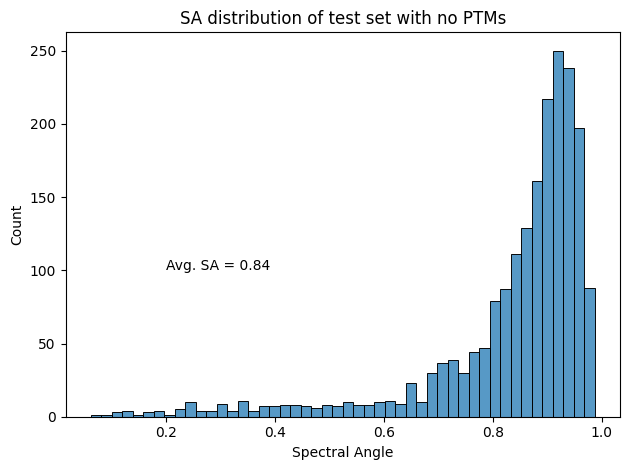

In [11]:
# distribution of spectral angles on baseline test set
sa_baseline = [1 - sd for sd in sd_baseline]
avg_sa_baseline = np.mean(sa_baseline)
p = sns.histplot(sa_baseline)
p.text(0.2, 100, f'Avg. SA = {avg_sa_baseline:.2}')
plt.title('SA distribution of test set with no PTMs')
plt.xlabel('Spectral Angle')
plt.tight_layout()

In [12]:
# check the shape of the weights of the embedding layer
# 58 for the alphabet size and 16 for the embeddings
# each input sequence of shape (n, 1) is mapped to the respective embedding resulting in shape (n, 16)
model.layers[0].get_weights()[0].shape

(27, 16)

In [13]:
# alphabet that contains all naive mods as well as the K modification Fromyl -> dataset at /cmnfs/data/proteomics/Prosit_PTMs/21PTMs/Kmod_Formyl.parquet
from dlomix.constants import ALPHABET_NAIVE_MODS
ALPHABET_NAIVE_MODS.update({'K[UNIMOD:122]': 26})
print(ALPHABET_NAIVE_MODS)

{'C[UNIMOD:4]': 24, 'M[UNIMOD:35]': 25, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '[]-': 21, '-[]': 22, '[UNIMOD:737]-': 21, 'K[UNIMOD:122]': 26}


In [14]:
# load a small dataset which contains only the new modification K[UNIMOD:122] as well as the other ones present in ALPHABET_NAIVE_MODS
data = load_processed_dataset('/cmnfs/proj/bmpc_dlomix/datasets/processed/kmod_formyl')

In [15]:
from collections import Counter
c = Counter()
total_seqs = 0
for batch, _ in data.tensor_train_data:
    for seq in batch['modified_sequence'].numpy():
        c.update(seq)
        total_seqs += 1
    for k, v in ALPHABET_NAIVE_MODS.items():
        if v == batch['modified_sequence'].numpy().max():
            print(f'Modification {k} is correctly encoded and present in the current batch')

Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch


In [16]:
print(f'Total of {c[26]} istances of the new modification in {total_seqs} are present')

Total of 5807 istances of the new modification in 7169 are present


In [17]:
# predict the intensities and calculate spectral distance between predictions and true intensities
sd_new_mod = list()
for batch, y_true in data.tensor_val_data:
    print('Max value: ', batch['modified_sequence'].numpy().max())
    print('Min value: ', batch['modified_sequence'].numpy().min())
    y_pred = model.predict(batch)
    sd_new_mod.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

Max value:  26
Min value:  0
32/32 [==============================] - 0s 9ms/step
Max value:  26
Min value:  0
25/25 [==============================] - 0s 10ms/step


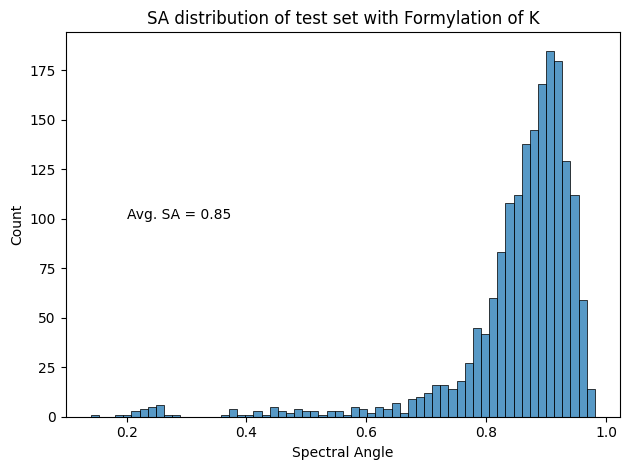

In [18]:
# distribution of spectral angles on the dataset with new modification
sa_new_mod = [1 - sd for sd in sd_new_mod]
avg_sa_new_mod = np.mean(sa_new_mod)
q = sns.histplot(sa_new_mod)
q.text(0.2, 100, f'Avg. SA = {avg_sa_new_mod:.2}')
plt.title('SA distribution of test set with Formylation of K')
plt.xlabel('Spectral Angle')
plt.tight_layout()

### Try to only allow the new embeddings to train

In [19]:
from dlomix.models import PrositIntensityPredictor
def change_input_layer(model: PrositIntensityPredictor, modifications: list = None) -> None:
    if modifications:
        for new_mod in modifications:
            model.alphabet.update({new_mod: max(model.alphabet.values()) + 1})

    model.embedding = tf.keras.layers.Embedding(
        input_dim=len(model.alphabet) + 2,
        output_dim=model.embedding_output_dim,
        input_length=model.seq_length,
        name='embedding'
    )

In [20]:
# get the weights from the old embedding layer
old_embedding_weights = model.layers[0].get_weights()[0]
print(f'Shape of the old embeddings: {old_embedding_weights.shape}')

Shape of the old embeddings: (27, 16)


In [21]:
# initialize the new embedding weights with a random initialization and the new shape -> use updated alphabet
new_embedding_weights = tf.Variable(tf.random.normal([len(model.alphabet) + 3, old_embedding_weights.shape[1]]))
print(f'Shape of weights for new embedding layer: {new_embedding_weights.shape}')

Shape of weights for new embedding layer: (28, 16)


In [22]:
# set the old embedding weights as the first len(model.old_alphabet) + 2 embeddings
new_embedding_weights[:old_embedding_weights.shape[0], :].assign(old_embedding_weights)
# randomly initialize the new embedding dimensions
new_embedding_weights[old_embedding_weights.shape[0]:, :].assign(tf.random.normal([1, old_embedding_weights.shape[1]]))
print(f'New embeddings are the same as old embeddings: {np.all(old_embedding_weights == new_embedding_weights[:old_embedding_weights.shape[0], :])}')

New embeddings are the same as old embeddings: True


In [23]:
# change the input layer such that new modification can be implemented
change_input_layer(model, ['K[UNIMOD:122]'])

In [24]:
# build the new layer to initialize random weights
model.get_layer('embedding').build((None,))
print(f'Shape of newly build embedding layer is: {model.get_layer("embedding").get_weights()[0].shape}')

Shape of newly build embedding layer is: (28, 16)


In [25]:
# set the old weights + the new embedding layer to the layer weights
model.get_layer('embedding').set_weights([new_embedding_weights])

In [26]:
print(f'Embedding layer weight shape after changing output layer: {model.get_layer(name="embedding").get_weights()[0].shape}')
print(f'The weights from the embedding layer are the same as the old embedding layer for the first n-dimensions: {np.all(old_embedding_weights == model.get_layer("embedding").get_weights()[0][:old_embedding_weights.shape[0], :])}')

Embedding layer weight shape after changing output layer: (28, 16)
The weights from the embedding layer are the same as the old embedding layer for the first n-dimensions: True


### Test if one can apply a constraint during training to only allow the new embeddings to train

In [29]:
weights = model.get_layer('embedding').get_weights()[0]

In [30]:
from tensorflow.keras.constraints import Constraint
import keras.backend as K
class FixWeights(Constraint):
    def __init__(self, old_weights):
        self.old_weights = old_weights
    def __call__(self, w):
        return K.concatenate([self.old_weights, w[self.old_weights.shape[0]:]], axis=0)

In [ ]:
# Example usage
vocab_size = 28
embedding_dim = 16

old_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=30),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

old_model.compile(optimizer='adam', loss='binary_crossentropy')

# Dummy data
inputs = tf.random.uniform((15, 30), maxval=vocab_size, dtype=tf.int32)
labels = tf.random.uniform((15,), maxval=2, dtype=tf.int32)

old_model.fit(inputs, labels, epochs=100)

In [32]:
# get old model embedding weights
old_weights = old_model.layers[0].get_weights()[0]
old_weights.shape

(28, 16)

In [33]:
# build a new model with the FixWeights constraint
new_vocab_size = vocab_size + 1
new_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=new_vocab_size, output_dim=embedding_dim, input_length=30, embeddings_constraint=FixWeights(old_weights=old_weights)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

new_model.compile(optimizer='adam', loss='binary_crossentropy')

# Dummy data
new_inputs = tf.random.uniform((15, 30), maxval=new_vocab_size, dtype=tf.int32)
new_labels = tf.random.uniform((15,), maxval=2, dtype=tf.int32)

In [34]:
# get the untrained last embedding slice 
new_embedding = new_model.layers[0].get_weights()[0][27]
new_embedding.shape

(16,)

In [ ]:
new_model.fit(new_inputs, new_labels, epochs=100)

In [36]:
new_weights = new_model.layers[0].get_weights()[0]
new_weights.shape

(29, 16)

In [37]:
print(f'The old and the new embedding weights are the same: {np.all(old_weights[:27] == new_weights[:27])}')

The old and the new embedding weights are the same: True


In [38]:
new_embedding_trained = new_model.layers[0].get_weights()[0][27]
print(f'The new embedding layer is the same as before training: {np.any(new_embedding == new_embedding_trained)}')

The new embedding layer is the same as before training: False


-> all the old embeddings stayed the same, the new embedding was trained

### See if the constraint approach can be applied to the prosit network

In [39]:
from dlomix.models import PrositIntensityPredictor
import keras.backend as K
from tensorflow.keras.constraints import Constraint

class FixWeights(Constraint):
    def __init__(self, old_weights):
        self.old_weights = old_weights
        self.freeze_weights = True

    def __call__(self, w):
        if self.freeze_weights:
            # because of the 'unused' embedding entry -> substract 1 from the shape and allow the last two embedding shapes to train
            new_w =  K.concatenate([self.old_weights[:self.old_weights.shape[0] - 1], w[self.old_weights.shape[0] - 1:]], axis=0)
            return new_w
        else:
            return w

    

def change_input_layer(model: PrositIntensityPredictor, modifications: list = None, freeze_old_embeds: bool = False) -> None:
    if modifications:
        model.alphabet.update({k: i for i, k in enumerate(modifications, start=len(model.alphabet) + 1)})
        
    embeddings_constraint = None
    if freeze_old_embeds:
        # if added names to the model, replace get_layer index with name 
        trained_embeds_weights = model.layers[0].get_weights()[0]
        embeddings_constraint = FixWeights(trained_embeds_weights)

    model.embedding = tf.keras.layers.Embedding(
        input_dim=len(model.alphabet) + 2,
        output_dim=model.embedding_output_dim,
        input_length=model.seq_length,
        embeddings_constraint=embeddings_constraint,
        name='embedding'
        )

In [40]:
# use a Custom Callback to check if the weights of the new embedding layer changes
class PrintWeights(tf.keras.callbacks.Callback):
    def __init__(self, index):
        super().__init__()
        self.index = index
    def on_epoch_end(self, epoch, logs=None):
        print(self.model.get_layer('embedding').get_weights()[0][self.index])

In [41]:
# load a small dataset containing the new modification
data = load_processed_dataset('/cmnfs/proj/bmpc_dlomix/datasets/processed/kmod_formyl')

In [42]:
# load the model
model = tf.keras.models.load_model(MODEL_DIR + RUN_NAME + '.keras')

In [43]:
# get the trained weights from the embedding layer
old_w = model.layers[0].get_weights()[0]
old_w.shape

(27, 16)

In [44]:
# change the embedding layer 
change_input_layer(model, modifications=['K[UNIMOD:122]'], freeze_old_embeds=True)

In [45]:
# freeze everything except the embedding layer
def freeze_model(model:dlomix.models.prosit.PrositIntensityPredictor, trainable_first_layer:bool = False, trainable_last_layer:bool = False) -> None:
    model.trainable = True 
    for lay in model.layers:
        try:
            for sublay in lay.layers:
                sublay.trainable = False
        except (AttributeError):
            lay.trainable = False

    if (trainable_first_layer):
        first_layer = model.get_layer(name="embedding")
        first_layer.trainable = True

    if (trainable_last_layer):
        last_layer = model.get_layer(name = "sequential_4").get_layer(name = "time_dense")
        last_layer.trainable = True
freeze_model(model, trainable_first_layer=True)

In [46]:
# check the embeddings constraint
model.get_layer('embedding').embeddings_constraint

In [47]:
# recompile the model
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=masked_spectral_distance)

In [48]:
model.alphabet

{'C[UNIMOD:4]': 24,
 'M[UNIMOD:35]': 25,
 'A': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'Y': 20,
 '[]-': 21,
 '-[]': 22,
 '[UNIMOD:737]-': 21,
 'K[UNIMOD:122]': 26}

In [49]:
# train the model on the dataset containing the new modification for two epochs
model.fit(
    data.tensor_train_data,
    validation_data=data.tensor_val_data,
    epochs=2,
    callbacks=[PrintWeights(index=model.alphabet['K[UNIMOD:122]'])]
)

Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.2686[ 0.00951153  0.02825438  0.00858471  0.03224173 -0.01949676 -0.03231857
 -0.01503084  0.04096214 -0.04882079  0.03091751  0.03665249 -0.0488998
 -0.00484669 -0.04642855 -0.04924761 -0.04871641]
8/8 [==============================] - 8s 384ms/step - loss: 0.2686 - val_loss: 0.1835
Epoch 2/2
7/8 [=========================>....] - ETA: 0s - loss: 0.1865[ 0.01028507  0.02752161  0.00779809  0.03145138 -0.02026048 -0.03153876
 -0.01581676  0.04019156 -0.04898028  0.03012401  0.03585217 -0.04967691
 -0.00407051 -0.04721371 -0.04846415 -0.04792771]
8/8 [==============================] - 2s 201ms/step - loss: 0.1865 - val_loss: 0.1818


In [50]:
# retrieve the weigths of the new embedding layer
new_w = model.get_layer('embedding').get_weights()[0]
new_w.shape

(28, 16)

In [51]:
# check if the old embedding weights are the same
print(f'The weights for the old embeddings are the same as before training: {np.all(old_w[:26] == new_w[:26])}')

The weights for the old embeddings are the same as before training: True


In [52]:
print(f'The weights of the new embedding did not change: {np.all(old_w[26] == new_w[26])}')

The weights of the new embedding did not change: False


### Check if the constraint can be lifted after a specified number of epochs

In [125]:
from keras.callbacks import Callback
class ReleaseTrainedEmbeddings(Callback):
    def __init__(self, removal_epoch):
        super().__init__()
        self.removal_epoch = removal_epoch
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.removal_epoch:
            print(f'Removing Constraint from the Embedding layer at the end of epoch {epoch + 1}')
            print(f"Freeze Weight parameter of embeddings constraint: {self.model.get_layer('embedding').embeddings_constraint.freeze_weights}")
            self.model.get_layer('embedding').embeddings_constraint.freeze_weights = False
            print(f"Freeze Weight parameter of embeddings constraint: {self.model.get_layer('embedding').embeddings_constraint.freeze_weights}")
        print(f'Current status of the freeze variable: {self.model.get_layer("embedding").embeddings_constraint.freeze_weights}')
        # print(f'Weights of the last embedding layer: {self.model.get_layer("embedding").get_weights()[0][-1]}')
        return super().on_epoch_begin(epoch, logs)

**Problem:** The model cannot be recompiled inside a Custom Callback -> have to stop the training, remove the constraint, compile the model again and than restart the training

In [53]:
def remove_embeddings_constraint(model: PrositIntensityPredictor):
    print(f"Freeze Weight parameter of embeddings constraint before removing: {model.get_layer('embedding').embeddings_constraint.freeze_weights}")
    model.get_layer('embedding').embeddings_constraint.freeze_weights = False
    print(f"Freeze Weight parameter of embeddings constraint after removing: {model.get_layer('embedding').embeddings_constraint.freeze_weights}")

In [54]:
model = tf.keras.models.load_model(MODEL_DIR + RUN_NAME + '.keras')

In [55]:
old_w = model.layers[0].get_weights()[0]
old_w.shape

(27, 16)

In [56]:
change_input_layer(model, modifications=['K[UNIMOD:122]'], freeze_old_embeds=True)

In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=masked_spectral_distance
)

In [58]:
# fit the model for one epoch and check the weights of the embeddings
model.fit(
    data.tensor_train_data,
    validation_data=data.tensor_val_data,
    epochs=1,
    callbacks=[PrintWeights(index=model.alphabet['K[UNIMOD:122]'])]
)

8/8 [==============================] - ETA: 0s - loss: 0.2329[ 0.03852899 -0.02042289 -0.01456864  0.03750365  0.02631697 -0.04211094
 -0.04854193 -0.01988359 -0.02496628  0.01367044 -0.04318799  0.0446332
 -0.01751333  0.02484797 -0.03581357 -0.03468513]
8/8 [==============================] - 10s 365ms/step - loss: 0.2329 - val_loss: 0.1260


In [59]:
# check if the embedding weights did change
new_w = model.get_layer('embedding').get_weights()[0]
print(f'The weights for the old embeddings are the same as before training: {np.all(old_w[:26] == new_w[:26])}')
print(f'The weights for the new embeddings are the same as before training: {np.all(old_w[26] == new_w[26])}')

The weights for the old embeddings are the same as before training: True
The weights for the new embeddings are the same as before training: False


In [61]:
old_w = model.get_layer('embedding').get_weights()[0]

In [60]:
# remove the constraint
remove_embeddings_constraint(model)

Freeze Weight parameter of embeddings constraint before removing: True
Freeze Weight parameter of embeddings constraint after removing: False


In [62]:
# recompile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=masked_spectral_distance
)

In [64]:
# fit the model for another epoch and check the weights
model.fit(
    data.tensor_train_data,
    validation_data=data.tensor_val_data,
    epochs=1
)

8/8 [==============================] - 9s 367ms/step - loss: 0.1276 - val_loss: 0.1104


In [65]:
new_w = model.get_layer('embedding').get_weights()[0]

In [66]:
print(f'The weights for the old embeddings are the same as before training: {np.all(old_w[:26] == new_w[:26])}')
print(f'The weights for the new embeddings are the same as before training: {np.all(old_w[26] == new_w[26])}')

The weights for the old embeddings are the same as before training: False
The weights for the new embeddings are the same as before training: False


-> After removing the constraint and training the model fo another epoch, the embedding constraint of the layer is not in place anymore. \
The old embedding weights and the trained embedding weights do not match as before

In [106]:
# test if the changed model can be saved and loaded again after changing the input layer
model.save('test_changed_model.keras', save_format='keras')

In [101]:
model_2 = tf.keras.models.load_model('test_changed_model.keras', compile=False)

In [108]:
# model can be loaded again and can be used to predict
for batch, _ in data.tensor_val_data:
    y_pred = model_2.predict(batch)

25/25 [==============================] - 1s 10ms/step
